# 라이브러리 import

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# 입력 이미지 정의

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)    # 입력 이미지의 차원(mnist의 크기는 28 x 28, 흑백이므로 채널은 1)

z_dim = 100 # 생성자의 입력으로 사용될 잡음 벡터의 크기

# 생성자

In [ ]:
def build_generator(img_shape, z_dim):
  model = Sequential()

  model.add(Dense(128, input_dim=z_dim))    # 완전 연결층, input_dim은 정의한 노이즈 벡터값을 받음
  model.add(LeakyReLU(alpha=0.01))    # LeakyReLU 활성화 함수
  model.add(Dense(28 * 28 * 1, activation='tanh'))    # tanh 활성화 함수를 사용한 출력층
  model.add(Reshape(img_shape))   # 생성자 출력을 이미지 차원으로 변경
  return model

# LeakyReLU는 음수 입력을 모두 0으로 만드는 일반적인 ReLU 함수와 달리 작은 기울기를 사용하여
# 훈련중에 Gradient가 사라지는 것을 막아 훈련 결과를 향상시킨다.

# tanh은 출력값을 [-1, 1] 범위로 조정한다.
# tanh은 시그모이드 함수보다 조금 더 또렷한 이미지를 생성한다.


# 식별자

In [ ]:
def build_discriminator(img_shape):
  model = Sequential()
  model.add(Flatten(input_shape=img_shape))   # flatten을 활용하여 입력 이미지를 일렬로 펼치기
  model.add(Dense(128)) # 완전 연결층
  model.add(LeakyReLU(alpha=0.01))    # LeakyReLU 활성화 함수
  model.add(Dense(1, activation='sigmoid'))   # sigmoid 활성화 함수를 사용한 출력층
  return model


# 모델 생성

- Generator를 훈련하기 위해 연결된 모델에서는 Discriminator의 파라미터를 동결하기 위해 discriminator.trainable = False로 지정한다.
- 판별자를 훈련하지 않도록 설정함으로써 모델은 생성자만 훈련시킨다.

In [ ]:
def build_gan(generator, discriminator):
  model = Sequential()
  # 생성자 + 판별자로 연결된 모델
  model.add(generator)    
  model.add(discriminator)
  return model


In [ ]:
# 판별자 모델을 만들고 컴파일하기
discriminator = build_discriminator(img_shape)    # 판별자 모델 생성하고 컴파일하기 
discriminator.compile(loss='binary_crossentropy',   # 이진분류이므로 binary_crossentropy 사용
                      optimizer=Adam(),            # optimizer 함수로 Adam을 사용
                      metrics=['accuracy'])

generator = build_generator(img_shape, z_dim)   # 생성자 모델 생성하기

discriminator.trainable = False   # 생성자 훈련할 때 판별자 파라미터 동결시키기

gan = build_gan(generator, discriminator)
# 생성자 훈련하기 위해 동결한 판별자로 GAN 모델 만들고 컴파일하기
gan.compile(loss='binary_crossentropy',
            optimizer=Adam())

# 훈련
- 랜덤한 MNIST 이미지의 미니배치를 진짜 샘플로 받고 랜덤한 노이즈 벡터 z로부터 가짜 이미지의 미니배치를 생성한다.
- 이를 사용해 생성자의 파라미터를 고정한 채로 판별자 네트워크를 훈련한다.
- 그다음 가짜 이미지의 미니배치를 생성하고 이를 사용해 판별자의 파라미터를 고정한 채로 생성자 네트워크를 훈련한다.
- 이 과정을 반복한다.


판별자는 가짜 이미지에 0 레이블을 할당하고, 진짜 이미지에 1 레이블을 할당하도록 훈련된다.</br>
생성자는 자신이 만든 가짜 샘플에 판별자가 1 레이블을 할당하게끔 훈련된다.</br>
생성자는 출력층에 tanh 활성화 함수를 사용하기 때문에 가짜 이미지는 (-1, 1) 범위의 값을 가진다. 따라서 모든 판별자의 입력을 동일한 범위로 바꿔 주어야 한다.

# GAN 훈련 반복

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
  # mnist 데이터 로드하기
  (X_train, _), (_, _) = mnist.load_data()

  # [0, 255]의 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정하기
  X_train = X_train / 127.5 - 1.0
  X_train = np.expand_dims(X_train, axis=3)

  # 진짜 이미지 레이블: 모두 1
  real = np.ones((batch_size, 1))

  # 가짜 이미지 레이블: 모두 0
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):
    # -------------------------
    #  판별자 훈련
    # -------------------------

    # 진짜 이미지에서 랜덤 배치 가져오기
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # 가짜 이미지 배치 생성
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # discriminator(판별자) 훈련
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # -------------------------
    #  생성자 훈련
    # -------------------------

    # 가짜 이미지 배치 생성
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # 생성자 훈련
    g_loss = gan.train_on_batch(z, real)

    if (iteration + 1) % sample_interval == 0:

      # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoint.append(iteration + 1)

      # 훈련 과정 출력
      print(f'{iteration + 1} [D 손실: {d_loss}, 정확도: {100.0 * accuracy}, G 손실: {g_loss}')

      # 생성된 이미지 샘플 출력
      sample_images(generator)




In [ ]:
def sample_images(generator, image_grid_rows = 4, image_grid_columns = 4):
  # 랜덤한 노이즈 샘플링
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

  # 랜덤한 잡음에서 이미지 생성하기
  gen_imgs = generator.predict(z)

  # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
  gen_imgs = 0.5 * gen_imgs + 0.5

  # 이미지 그리드 설정
  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(4,4),
                          sharey=True,
                          sharex=True)
  
  cnt = 0

  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      # 이미지 그리드 출력
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

# GAN 훈련과 출력 점검
케라스의 'Discrepancy between trainable weights and collected trainable' 경고는 예상한 것입니다. 원래 설계가 판별자를 훈련하는 동안 생성자의 훈련 파라미터를 고의로 일정하게 유지했고 그 반대의 경우도 마찬가지입니다.

- 올바른 반복횟수나 배치 사이즈를 결정할 수 있는 믿을 만한 방법이 없다.
- 미니배치는 프로세스 메모리에 들어갈 수 있도록 충분히 작아야 한다.
- 일반적으로 미니배치 크기는 2의 배수이다.(32, 64, 128, 256, 512 ...)
- 적절한 반복 횟수를 결정하려면 훈련 손실을 모니터링하고 손실이 평탄해지는 부근에서 반복횟수를 정한다.

1000 [D 손실: 0.01940874010324478, 정확도: 99.21875, G 손실: 8.09066390991211
2000 [D 손실: 0.0929291807115078, 정확도: 96.09375, G 손실: 6.13151741027832
3000 [D 손실: 0.18710795044898987, 정확도: 91.796875, G 손실: 3.9240939617156982
4000 [D 손실: 0.14038651809096336, 정확도: 93.75, G 손실: 4.597043991088867
5000 [D 손실: 0.13016589730978012, 정확도: 92.96875, G 손실: 5.6423540115356445
6000 [D 손실: 0.24398697167634964, 정확도: 90.625, G 손실: 4.102659702301025
7000 [D 손실: 0.32853030413389206, 정확도: 85.9375, G 손실: 4.125540256500244
8000 [D 손실: 0.4099425822496414, 정확도: 81.25, G 손실: 3.24768328666687
9000 [D 손실: 0.39252230525016785, 정확도: 80.46875, G 손실: 3.6698193550109863
10000 [D 손실: 0.5925871580839157, 정확도: 75.390625, G 손실: 3.043156623840332
11000 [D 손실: 0.2955140918493271, 정확도: 87.890625, G 손실: 3.469803810119629
12000 [D 손실: 0.28860078752040863, 정확도: 89.0625, G 손실: 3.3979411125183105
13000 [D 손실: 0.625563308596611, 정확도: 75.390625, G 손실: 2.393238067626953
14000 [D 손실: 0.39811067283153534, 정확도: 84.375, G 손실: 2.7600674629211426

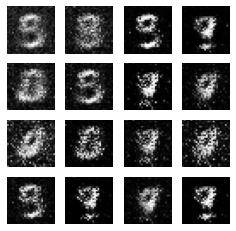

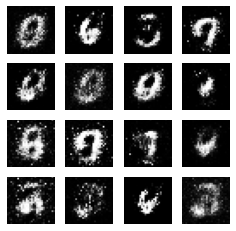

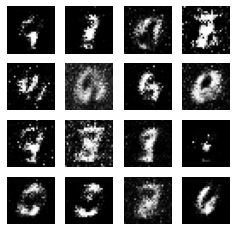

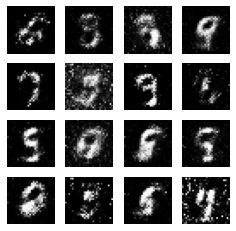

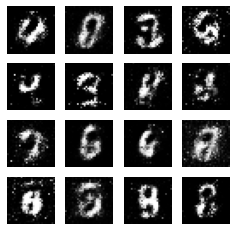

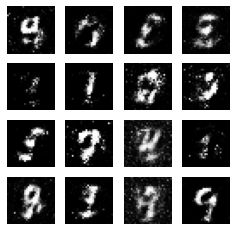

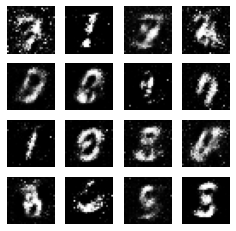

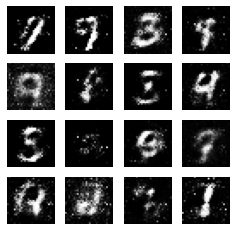

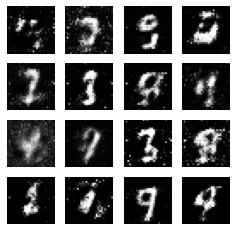

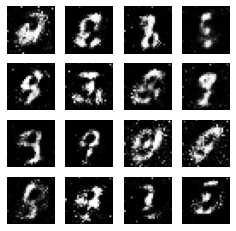

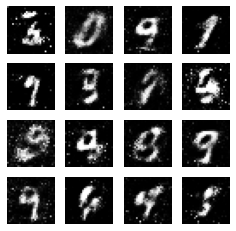

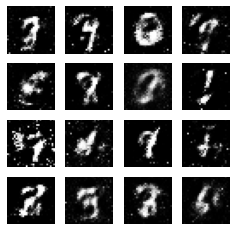

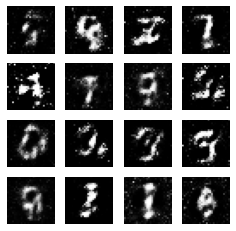

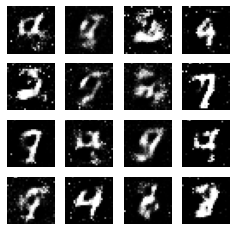

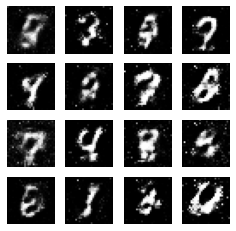

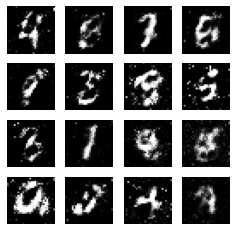

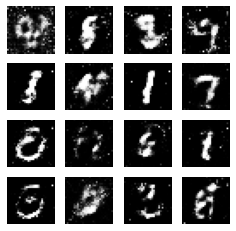

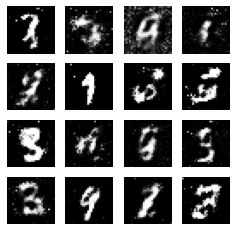

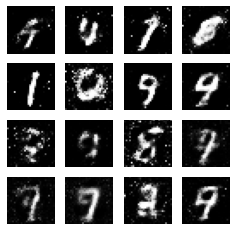

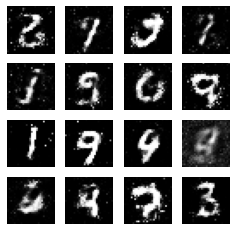

In [ ]:
# 하이퍼 파라미터 설정
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

In [ ]:
losses = np.array(losses)

# 판별자와 생성자의 훈련 손실 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label= 'Discriminator loss')
plt.plot(iteration_checkpoints, losses.T[1], label= 'Generator loss')

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

IndexError: ignored

<Figure size 1080x360 with 0 Axes>

In [ ]:
accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()